In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from torch import Tensor
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

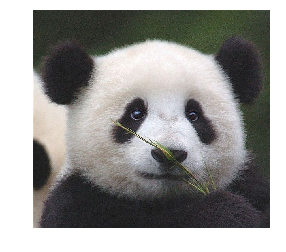

In [2]:
image = Image.open('../svm/dataset/panda/jxC2wR_panda.png')
fig = plt.figure()
plt.axis("off")
plt.imshow(image)

In [3]:
# resize to 224x224x3 and type is tensor
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(image)
x = x.unsqueeze(0) 
x.shape

torch.Size([1, 3, 224, 224])

### Embedding

In [4]:
class Embedding(nn.Module):
    def __init__(self, 
                 in_channels: int = 3, 
                 patch_size: int = 16, 
                 em_size: int = 768, 
                 img_size: int = 224
                ):
        self.patch_size = patch_size
        super().__init__()
        self.linearProj = nn.Sequential(
            nn.Conv2d(in_channels, em_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls = nn.Parameter(torch.randn(1,1, em_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, em_size))
        # position embedding

        
    def forward(self, 
                x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.linearProj(x)
        cls_tokens = repeat(self.cls, '() n e -> b n e', b=b)
        # prepend the cls token
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

In [5]:
embedding=Embedding()
embedding(x).shape

torch.Size([1, 197, 768])

### Multi-Head Attention

In [6]:
class Multihead_Attention(nn.Module):
    def __init__(self, 
                 em_size: int = 768, # ViT-Base setting
                 num_heads: int = 8, # ViT-Base setting
                 dropout: float = 0
                ):
        super().__init__()
        self.em_size = em_size
        self.num_heads = num_heads
        self.kl = nn.Linear(em_size, em_size)
        self.ql = nn.Linear(em_size, em_size)
        self.vl = nn.Linear(em_size, em_size)
        self.att_drop = nn.Dropout(dropout)
        self.linearProj = nn.Linear(em_size, em_size)
        self.scaling = (self.em_size // num_heads) ** -0.5
    
    def attention(self, 
                x : Tensor, 
                mask: Tensor = None) -> Tensor:
        # split k,q,v
        q = rearrange(self.ql(x), "b n (h d) -> b h n d", h=self.num_heads)
        k = rearrange(self.kl(x), "b n (h d) -> b h n d", h=self.num_heads)
        v  = rearrange(self.vl(x), "b n (h d) -> b h n d", h=self.num_heads)
        att = torch.einsum('bhqd, bhkd -> bhqk', q, k) 
        if mask is not None: # mask is opts.
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        att = F.softmax(att, dim=-1) * self.scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, v)
        return out
        
    def forward(self, 
                x : Tensor, 
                mask: Tensor = None) -> Tensor:
        out = self.attention(x, mask)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.linearProj(out)
        return out

In [7]:
MultiHeadAttention = Multihead_Attention()
MultiHeadAttention(embedding(x)).shape

torch.Size([1, 197, 768])

In [8]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

### FeedForward

In [9]:
class FFNBlock(nn.Sequential):
    def __init__(self, 
                 em_size: int, 
                 expansion: int = 4, 
                 drop_p: float = 0.
                ):
        super().__init__(
            nn.Linear(em_size, expansion * em_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * em_size, em_size),
        )

In [10]:
embedded = embedding(x)

### Encoder Block

In [11]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 em_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs
                ):
        super().__init__(
            Residual(nn.Sequential(
                nn.LayerNorm(em_size),
                Multihead_Attention(em_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            Residual(nn.Sequential(
                nn.LayerNorm(em_size),
                FFNBlock(
                    em_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))
        
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [12]:
TransformerEncoderBlock()(embedded).shape

torch.Size([1, 197, 768])

In [13]:
class Classification(nn.Sequential):
    def __init__(self, em_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(em_size), 
            nn.Linear(em_size, n_classes))

### ViT

In [14]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3, 
                patch_size: int = 16, # ViT-Base setting
                em_size: int = 768, # ViT-Base setting
                img_size: int = 224, # ViT-Base setting
                depth: int = 12, # ViT-Base setting
                n_classes: int = 1000, # ViT-Base setting
                **kwargs
                ):
        super().__init__(
            Embedding(in_channels, patch_size, em_size, img_size),
            TransformerEncoder(depth, em_size=em_size, **kwargs),
            Classification(em_size, n_classes)
        )

In [15]:
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
         Embedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
Multihead_Attention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
         Residual-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 

       LayerNorm-125             [-1, 197, 768]           1,536
          Linear-126            [-1, 197, 3072]       2,362,368
            GELU-127            [-1, 197, 3072]               0
         Dropout-128            [-1, 197, 3072]               0
          Linear-129             [-1, 197, 768]       2,360,064
         Dropout-130             [-1, 197, 768]               0
        Residual-131             [-1, 197, 768]               0
       LayerNorm-132             [-1, 197, 768]           1,536
          Linear-133             [-1, 197, 768]         590,592
          Linear-134             [-1, 197, 768]         590,592
          Linear-135             [-1, 197, 768]         590,592
         Dropout-136          [-1, 8, 197, 197]               0
          Linear-137             [-1, 197, 768]         590,592
Multihead_Attention-138             [-1, 197, 768]               0
         Dropout-139             [-1, 197, 768]               0
        Residual-140             [-1,

In [16]:
vit=ViT()

In [17]:
vit(x)

tensor([[ 1.3260e-01, -1.1678e+00,  3.1965e-01,  5.1532e-01, -7.5497e-01,
          8.3200e-01, -7.4272e-01,  3.3238e-01, -8.3586e-01,  5.9758e-01,
          7.0792e-01,  1.0622e+00,  6.0497e-01, -6.0969e-01, -8.2023e-02,
          7.0588e-02,  2.5818e-01, -1.6358e+00,  2.1411e-01,  8.0906e-01,
         -9.3710e-01,  1.2046e-01, -1.0006e+00,  7.2649e-01,  1.6550e-01,
         -4.4690e-01,  5.6913e-01,  5.8679e-02, -3.5397e-01,  1.5997e-01,
          4.1964e-01, -9.1403e-01, -3.0512e-01,  2.0112e-01,  2.5369e-01,
          3.6992e-01,  3.7374e-03,  8.0436e-02,  2.9630e-01,  6.2523e-01,
         -2.8727e-01,  5.5596e-01, -2.8327e-01,  4.0209e-01, -3.5300e-01,
         -5.8773e-03, -3.0942e-01, -7.3792e-01, -9.4887e-01, -3.9780e-01,
         -5.0787e-01,  1.8887e-01,  2.4273e-01,  7.5411e-01,  6.3433e-01,
          3.1663e-02, -7.4720e-01,  4.1775e-01, -1.0982e+00,  8.4667e-01,
         -1.0427e+00, -3.9203e-01, -8.2282e-01, -3.1781e-01, -3.7882e-01,
          1.6279e-01, -3.1680e-01, -9.

### END